## Выполнил студент группы ББМО-01-23 Морин А.А.

### Шаг 1. Загрузка обученной модели и данных MNIST

In [42]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0

test_labels = to_categorical(test_labels, num_classes=10)

model = tf.keras.models.load_model('mnist_model.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.9723 - loss: 0.0974
Test accuracy on clean images: 0.9764000177383423


### Шаг 2: Реализация атаки Deepfool

tf.Tensor(7, shape=(), dtype=int64)


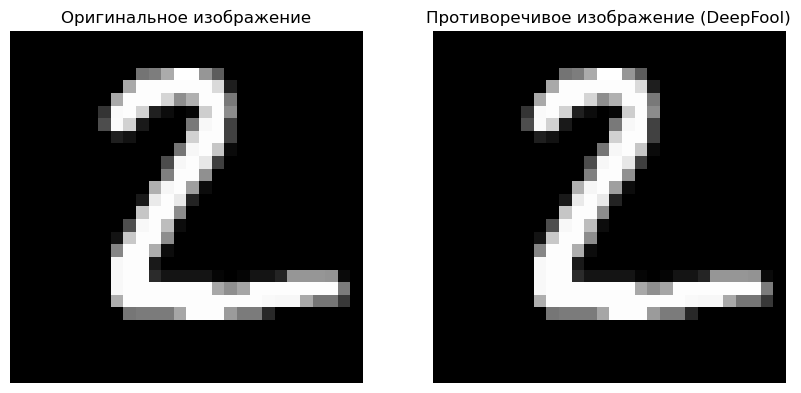

In [57]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

image = tf.convert_to_tensor(test_images[1], dtype=tf.float32)[None, ...]  # Добавляем размерность для батча
label = np.argmax(test_labels[0])  # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор

# Выполнение атаки
attack = fb.attacks.L2DeepFoolAttack(steps=10)
print(label)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)  # Оборачиваем метку в тензор с размерностью (1,)

# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (DeepFool)")
plt.imshow(advs[0].numpy(), cmap="gray")  # Предполагается, что advs имеет правильную форму
plt.axis('off')

plt.show()

### Шаг 3: Оценка модели на противоречивых примерах

In [50]:
adversarial_images = []

for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...] 
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0) 

adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (DeepFool): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.0000e+00 - loss: 141.9839
Accuracy on adversarial examples (DeepFool): 0.0


### Вывод:
Точность модели на атакованных примерах составляет около 0%. Такое падение точности говорит о том, что модель не справляется с задачей распознавания в условиях внесения небольших, но целенаправленных искажений.